In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")
%matplotlib notebook

import random as rn

In [2]:
RANDOM_SEED = 42
TRAINING_SAMPLE = 200_000
VALIDATE_SIZE = 0.2

np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
ds = pd.read_csv("/HDD/Data/credit-card-fraud-detection/creditcard.csv")
print(ds.shape)
ds.columns = map(str.lower, ds.columns)
ds.rename(columns={'class': 'label'}, inplace=True)
ds.head()

(284807, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Normalize ammount
Trun the amount feature into a normal distributed log equivalent


In [4]:
ds['log10_amount'] = np.log10(ds.amount + 0.00001)

## Visualising clusters with t-SNE
t-Distributed Stochastic Neighbor Empedding (t-SNE) <br>
Use only a small subsample to keep the computation time low.

In [5]:
# manual parameter 
RATIO_TO_FRAUD = 15

# dropping redundant columns
ds = ds.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = ds[ds.label == 1]
clean = ds[ds.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [6]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

<IPython.core.display.Javascript object>


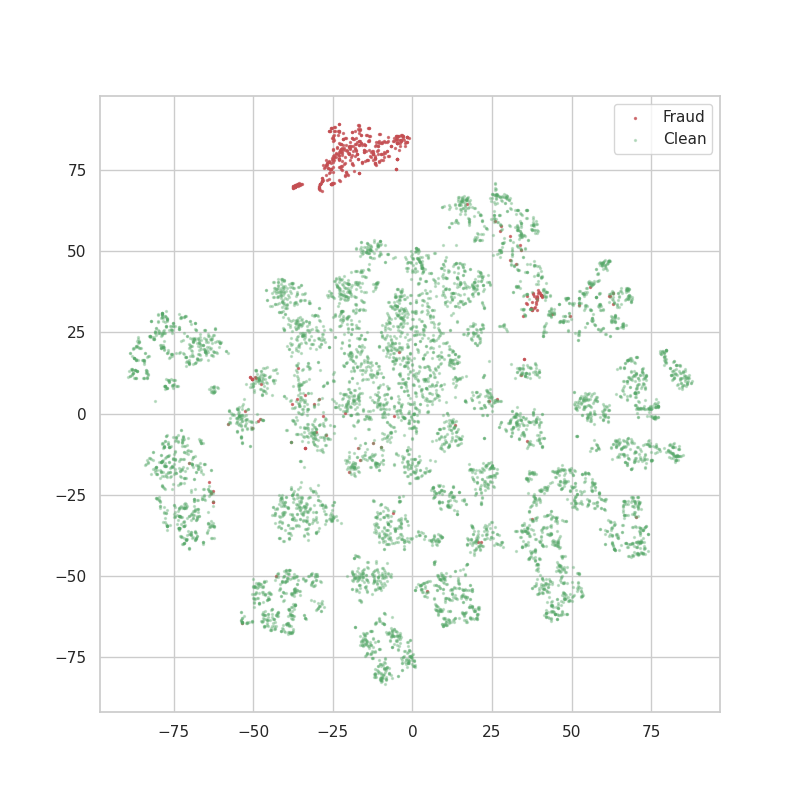

In [36]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

## Train validate and test split

The trick is to train the autoencoder only with data that is normal.

In [8]:
print(f'Shapes:\n\tClean: {clean.shape}\n\tFraud: {fraud.shape}')

Shapes:
	Clean: (284315, 30)
	Fraud: (492, 30)


In [9]:
#Shuffle the training set
clean = clean.sample(frac=1).reset_index(drop=True)

# non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [10]:
X_test.label.value_counts()

0    84315
1      492
Name: label, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_validate = train_test_split(X_train, test_size=VALIDATE_SIZE, random_state=RANDOM_SEED)
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [12]:
print(f"Final shapes:\n\tTraining {X_train.shape}\n\tValidate {X_validate.shape}\n\tTest {X_test.shape}")

Final shapes:
	Training (160000, 29)
	Validate (40000, 29)
	Test (84807, 29)


## Normalising and standarising

### The pipeline

In [13]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('normalizer', Normalizer()),
    ('scaler', MinMaxScaler())
])

### Fitting

In [14]:
pipeline.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

### Applying  the transformations

In [15]:
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

### Quick visualization

<IPython.core.display.Javascript object>


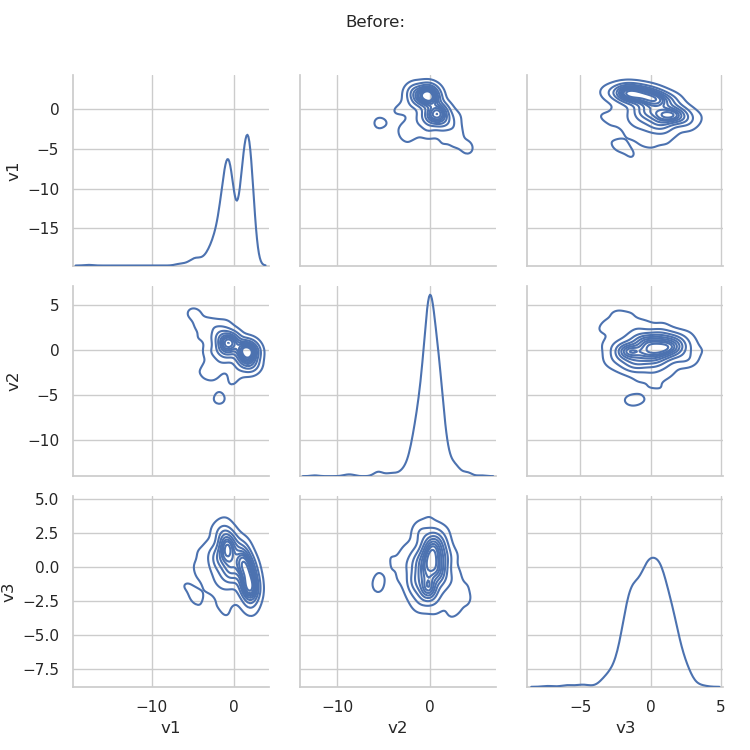

In [34]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

<IPython.core.display.Javascript object>


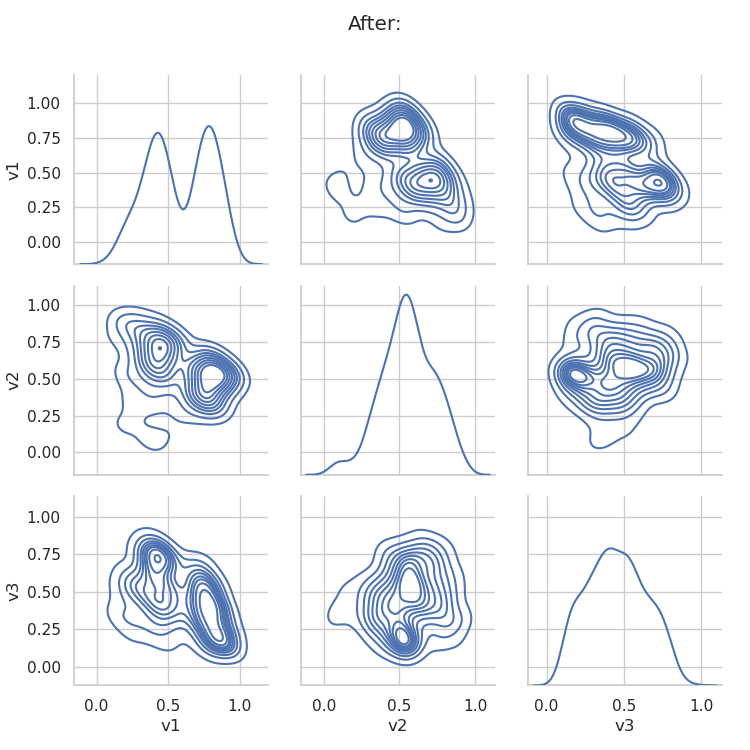

In [37]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

## Training the auto-encoder

In [18]:
# Load tensorboard
%load_ext tensorboard
%tensorboard --logdir logs

## Architecture of the model

In [19]:
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

autoencoder = tf.keras.models.Sequential([
    # Encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # Decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
])

autoencoder.compile(
    optimizer="adam",
    loss="mse",
    metrics=["acc"]
)

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 4

### Callbacks

In [20]:
from datetime import datetime

current = datetime.now().strftime('%Y%m%d%H%M')
subdir = f'{current}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{subdir}',
    update_freq='batch'
)

cb = [early_stop, save_model, tensorboard]

### Training!

In [21]:
history = autoencoder.fit(
    X_train_transformed, 
    X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
)

Epoch 1/100
625/625 [==============================] - 9s 15ms/step - loss: 0.0298 - acc: 0.2054 - val_loss: 0.0160 - val_acc: 0.2465
Epoch 2/100
625/625 [==============================] - 9s 15ms/step - loss: 0.0151 - acc: 0.2940 - val_loss: 0.0145 - val_acc: 0.3252
Epoch 3/100
625/625 [==============================] - 9s 14ms/step - loss: 0.0142 - acc: 0.3325 - val_loss: 0.0140 - val_acc: 0.3333
Epoch 4/100
625/625 [==============================] - 8s 14ms/step - loss: 0.0139 - acc: 0.3323 - val_loss: 0.0138 - val_acc: 0.3307
Epoch 5/100
625/625 [==============================] - 9s 15ms/step - loss: 0.0138 - acc: 0.3399 - val_loss: 0.0137 - val_acc: 0.3488
Epoch 6/100
625/625 [==============================] - 10s 16ms/step - loss: 0.0136 - acc: 0.3599 - val_loss: 0.0135 - val_acc: 0.3569
Epoch 7/100
625/625 [==============================] - 8s 12ms/step - loss: 0.0133 - acc: 0.3643 - val_loss: 0.0131 - val_acc: 0.3664
Epoch 8/100
625/625 [==============================] - 9s 14m

### Reconstruction

In [22]:
X_test_transformed = pipeline.transform(X_test)
reconstructions = autoencoder.predict(X_test_transformed)

#### Calculate the reconstruction loss

In [23]:
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

<IPython.core.display.Javascript object>


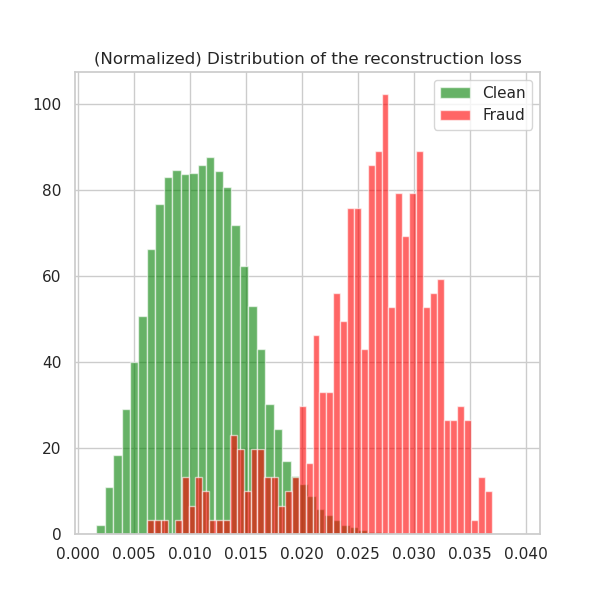

In [38]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(clean, bins=50, density=True, label='Clean', alpha=0.6, color='green')
ax.hist(fraud, bins=50, density=True, label='Fraud', alpha=0.6, color='red')

plt.title('(Normalized) Distribution of the reconstruction loss')
plt.legend()
plt.show()

## Get the outliers with MAD (Median Absolute Deviation)

In [25]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [26]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 602 outliers in a total of 84,807 transactions [0.71%].


## Verify the results

### Classification Matrix on MAD outliers

In [27]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve)

cm = confusion_matrix(y_test, outliers)

(tn, fp,
 fn, tp) = cm.flatten()

In [28]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[84050   265]
 [  155   337]]

% of transactions labeled as fraud that were correct (precision): 337/(265+337) = 55.98%
% of fraudulent transactions were caught succesfully (recall):    337/(155+337) = 68.50%


### Recall & precision
Adjust the MAD's Z-Score threshold

<IPython.core.display.Javascript object>


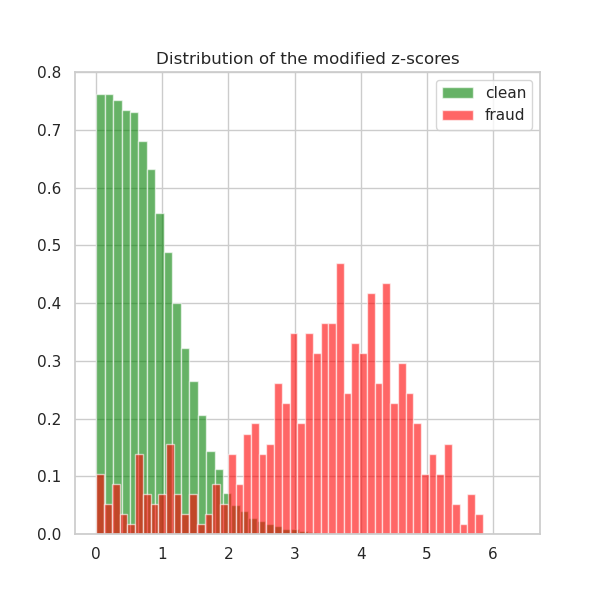

In [39]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

## Latent Space
Look at the compressed representation the neural network.

### Encoder

In [30]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
Total params: 1,532
Trainable params: 1,532
Non-trainable params: 0
_________________________________________________________________


### Undersampling
Undersample the clean transactions with the previous t-sne visualisation.

In [31]:
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * RATIO_TO_FRAUD, ]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

Clean transactions downsampled from 84,315 to 7,380.
Shape of latent representation: (7872, 2)


<IPython.core.display.Javascript object>


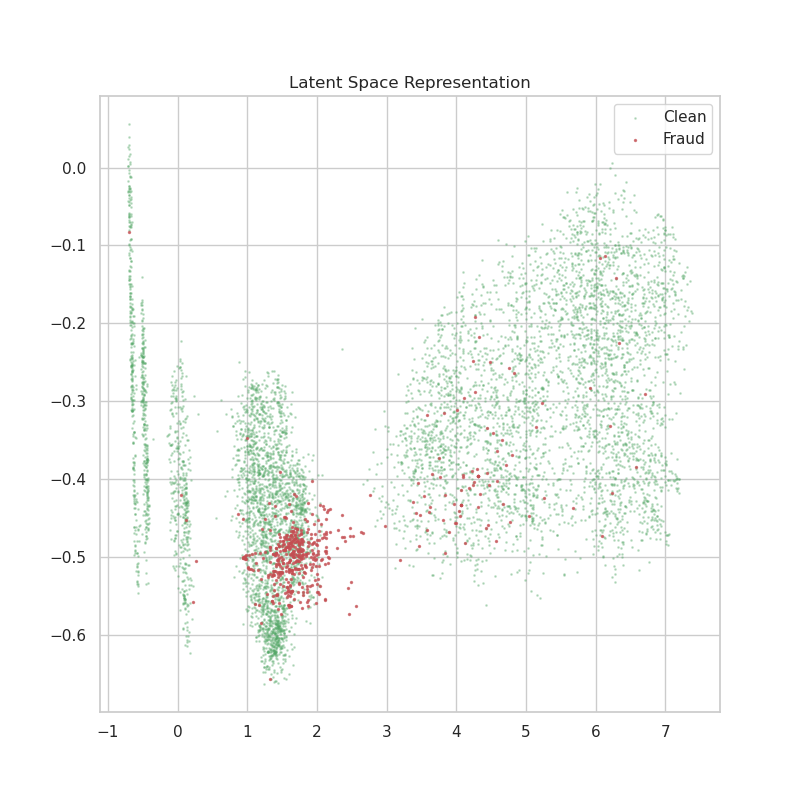

In [40]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()